In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 
import pywt

(CVXPY) Apr 04 03:50:17 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 04 03:50:17 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image, 0.15 was largest before
height,width = X.shape #getting height and width of image

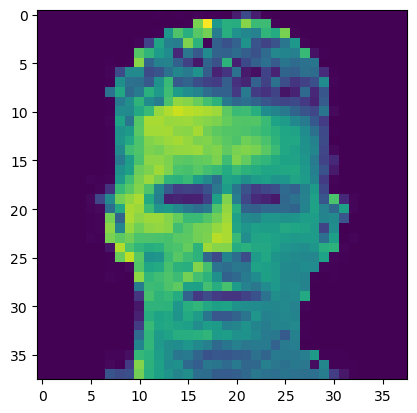

In [3]:
plt.imshow(X)

In [4]:
#Y = np.fft.fft2(X)
Y = pywt.dwt2(X, 'db1')

In [5]:
cA, (cH, cV, cD) = Y
len(cD)

19

In [6]:
Y = np.block([
    [cA,cH],
    [cV,cD]
])

In [7]:
y = np.array(Y)

In [8]:
width, height = Y.shape

In [9]:
y = Y.flatten()

In [10]:
y.shape

(1444,)

In [11]:
dim = y.size

In [12]:
Yz = Y.copy()
Yz[np.abs(Yz) < 200] = 0.

In [13]:
np.count_nonzero(Yz.real)

121

In [14]:
yz = Yz.flatten()

In [15]:
# A = np.random.randn(dim//2,dim)
# A = np.random.randint(0,2,size=(1444//2,1444))
A = np.random.randint(0,2,size=(dim//2,dim))

In [16]:

# square_size = 5
# yul = Yz[:square_size, :square_size]
# yur = Yz[:square_size, -square_size:]
# yll = Yz[-square_size:, :square_size]
# ylr = Yz[-square_size:, -square_size:]

# corners = np.block([[yul, yur],
#               [yll, ylr]])

# corners_flat = corners.flatten()

# stacked_corners = np.tile(corners_flat, 4)
# stacked_corners = stacked_corners[:dim]
# stacked_corners.shape

In [17]:
# num_rows_corners = stacked_corners.shape[0]
# size_of_A = (dim//2)*dim

# # sampled_indices = np.random.randint(0, num_rows_corners, size=size_of_A)
# sampled_indices = np.random.randint(0, size_of_A, size=size_of_A//10)

# # Create the new matrix by sampling rows from corners using the generated indices
# # A = stacked_corners[sampled_indices]
# # b = stacked_corners[sampled_indices]
# # A = np.zeros(size_of_A)
# # A[sampled_indices] = 1.
# # A.reshape(722,1444)
# # b = A@yz
# A = np.zeros(size_of_A)
# A[sampled_indices] = 1.
# A = A.reshape(dim//2,dim)
# yz = yz.reshape((-1, 1))

# #A = A.reshape(722,1444)
# #A.shape

In [18]:
b = A@yz

In [19]:
ysparsereal = cvx.Variable(dim)
# ysparsereal = ysparsereal.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(ysparsereal, 1))
constraints = [cvx.norm(A@ysparsereal - b.real,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [20]:
ysparseimag = cvx.Variable(dim)
# ysparseimag = ysparseimag.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(ysparseimag, 1))
constraints = [cvx.norm(A@ysparseimag - b.imag,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [21]:
ysparse = ysparsereal.value + ysparseimag.value*1j

In [22]:
Ysparse = ysparse.reshape((width,height))

(<matplotlib.image.AxesImage at 0x12354ead0>,
 <matplotlib.colorbar.Colorbar at 0x1235849d0>)

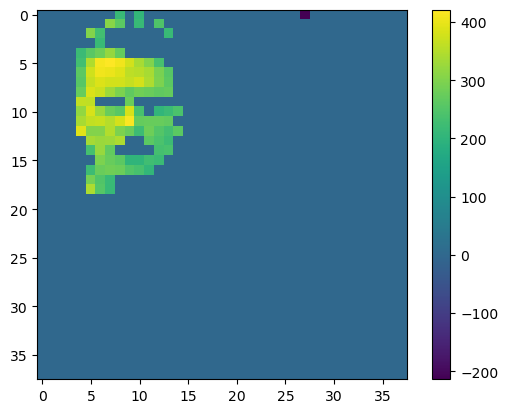

In [23]:
plt.imshow(Ysparse.real), plt.colorbar()

In [24]:
np.count_nonzero(Ysparse.real.round(8))

139

In [25]:
LL = Ysparse[:(width//2), :(height//2)]
HL = Ysparse[:(width//2), -(height//2):]
LH = Ysparse[-(width//2):, :(height//2)]
HH = Ysparse[-(width//2):, -(height//2):]

In [26]:
coeffs = (LL, (HL, LH, HH))

In [27]:
# Xhat = np.fft.ifft2(Ysparse).real
Xhat = pywt.idwt2(coeffs, 'db1').real

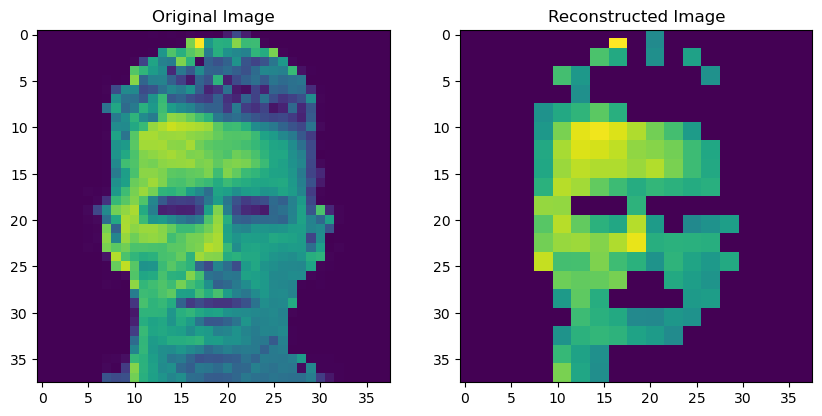

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(Xhat)
plt.title('Reconstructed Image')

plt.show()

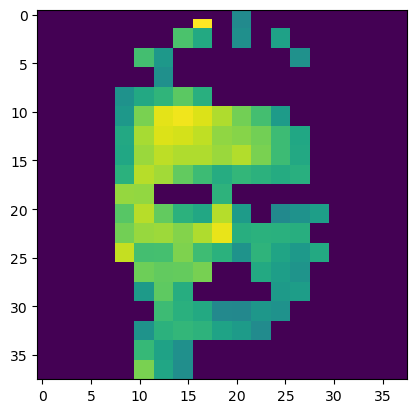

In [29]:
plt.imshow(Xhat)

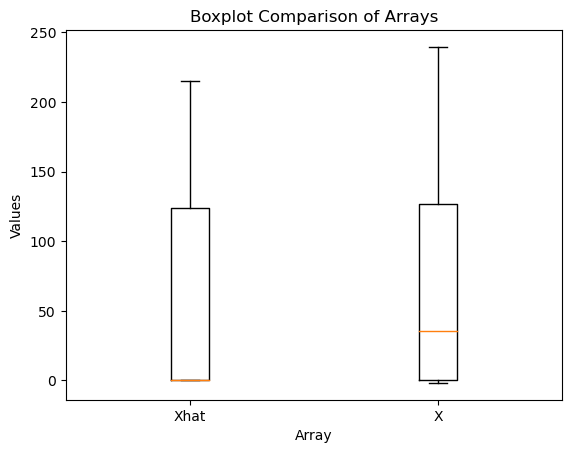

In [30]:
plt.boxplot([Xhat.flatten(), X.flatten()], labels=['Xhat', 'X'])
plt.title('Boxplot Comparison of Arrays')
plt.xlabel('Array')
plt.ylabel('Values')
plt.show()

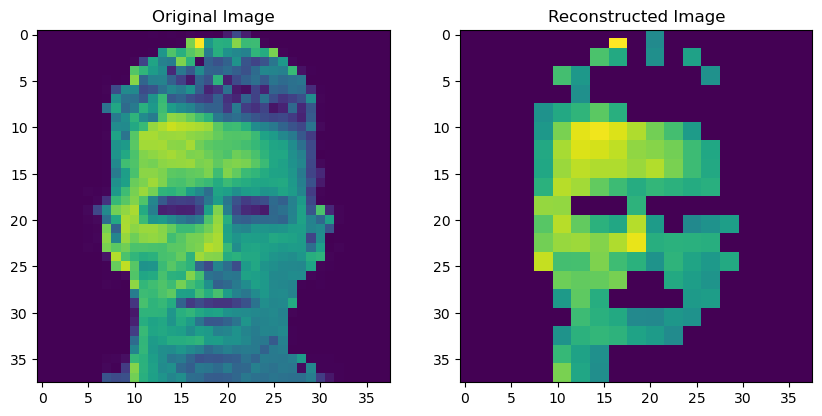

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(Xhat)
plt.title('Reconstructed Image')

plt.show()

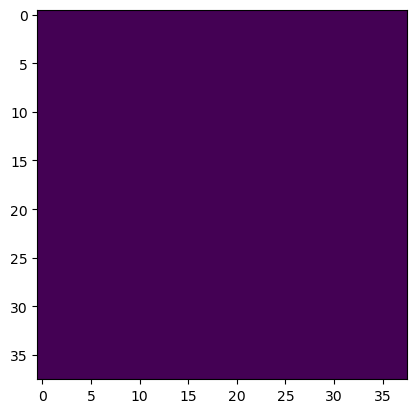

In [32]:
plt.imshow(Y.imag)